# Libraries Installation

In [1]:
!pip install -q anomalib
!pip install -q albumentations==1.3.1 --no-deps
!pip install -q qudida
!pip install -q lpips

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.8/831.8 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.5/228.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.5/828.5 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:0000:0100:01
  

In [2]:
import os, random, torch, numpy as np, pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pytorch_lightning import LightningDataModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Callback

print("CUDA:", torch.cuda.is_available(), 
      "| Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)
torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision("high")

def seed_all(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
seed_all(42)

CUDA: True | Device: Tesla T4


# Parameters & Tracking

In [3]:
config = {
    "dataset": "metal_nut",
    "params_dataset": {
        "image_size": 224,
        "train_batch_size": 32,
        "test_batch_size": 32,
        "num_workers": 4,
        "task": "segmentation",
        "seed": 42
    }
}

# Acceletor

In [4]:
import platform
print("CUDA:", torch.cuda.is_available(), "Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)
print("PyTorch:", torch.__version__, "| Python:", platform.python_version())

CUDA: True Device: Tesla T4
PyTorch: 2.6.0+cu124 | Python: 3.11.13


# MVTec Data

In [5]:
# Helper funcs + file dicts
import glob
from PIL import Image
from typing import Dict

def get_dataset_dict(dataset, subset):
    d = {}
    for f in glob.glob(f"/kaggle/input/mvtec-ad/{dataset}/{subset}/**/*.png", recursive=True):
        key = "/".join(f.split("/")[-2:]).replace(".png","")
        d[key] = f
    return d

# Datamodule

In [6]:
def get_category(key: str) -> str: return key.split("/")[0]
def get_label(key: str) -> str:    return "normal" if get_category(key) == "good" else "anomaly"
def get_label_index(key: str) -> int: return 0 if get_label(key)=="normal" else 1

images_train = get_dataset_dict(config["dataset"], "train")   # should be good/*
images_test  = get_dataset_dict(config["dataset"], "test")
_masks_raw   = get_dataset_dict(config["dataset"], "ground_truth")
masks_test   = {k[:-5]: v for k, v in _masks_raw.items()}     # align keys

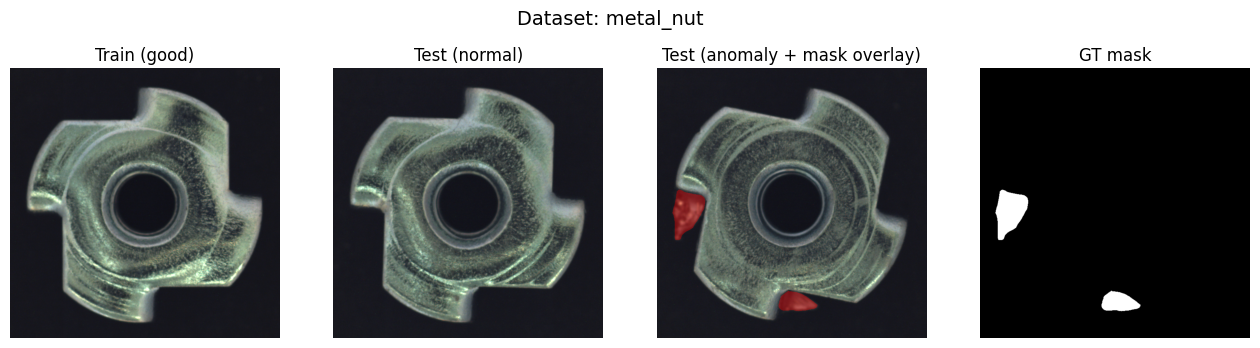

In [7]:
# --- pick samples ---
train_key = random.choice(list(images_train.keys()))
normal_keys = [k for k in images_test if k.startswith("good/")]
normal_key = random.choice(normal_keys)
anomaly_keys = [k for k in images_test if not k.startswith("good/") and k in masks_test]
anomaly_key = random.choice(anomaly_keys)

# --- load images/mask ---
train_img  = np.array(Image.open(images_train[train_key]).convert("RGB"))
normal_img = np.array(Image.open(images_test[normal_key]).convert("RGB"))
anom_img   = np.array(Image.open(images_test[anomaly_key]).convert("RGB"))
mask_img   = np.array(Image.open(masks_test[anomaly_key]).convert("L"))

# overlay mask in red on anomaly
overlay = anom_img.copy()
overlay[mask_img > 127] = [255, 0, 0]  # red overlay where mask=1
blended = (0.6*anom_img + 0.4*overlay).astype(np.uint8)

# --- plot ---
plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
plt.imshow(train_img)
plt.title("Train (good)")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(normal_img)
plt.title("Test (normal)")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(blended)
plt.title("Test (anomaly + mask overlay)")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(mask_img, cmap="gray")
plt.title("GT mask")
plt.axis("off")

plt.suptitle(f"Dataset: {config['dataset']}", fontsize=14)
plt.show()

In [8]:
# Transforms - Albumentations
IMG_SIZE = config["params_dataset"]["image_size"]  # 224
MEAN, STD = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

train_tf = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),          # optional, small & safe on 'metal_nut'
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2(),
])

eval_tf = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2(),
])

In [9]:
# Dataset classes (clean + reproducible)
class TrainGoodDataset(Dataset):
    def __init__(self, images: dict, transform: A.Compose):
        # deterministic order for reproducibility
        self.keys = sorted(images.keys())
        # guard: train should only contain good/*
        assert all(k.startswith("good/") for k in self.keys), "Leak: train contains anomalies."
        self.images = images
        self.t = transform

    def __len__(self): 
        return len(self.keys)

    def __getitem__(self, i):
        k = self.keys[i]
        # safe file handling
        with Image.open(self.images[k]).convert("RGB") as im:
            img = np.array(im)
        x = self.t(image=img)["image"]
        return {"image": x, "key": k}


class OfficialTestDataset(Dataset):
    def __init__(self, images: dict, masks: dict, transform: A.Compose, task="segmentation"):
        self.keys = sorted(images.keys())          # deterministic to fixed ordering for reproducible experiments
        self.images = images
        self.masks = masks
        self.t = transform
        self.task = task

    def __len__(self): 
        return len(self.keys)

    def __getitem__(self, i):
        k = self.keys[i]
        # with Image.open(self.images[k]).convert("RGB") as im:
        #     img = np.array(im)
        with Image.open(self.images[k]).convert("RGB") as im:
            img = np.asarray(im, dtype=np.uint8)

        label = get_label_index(k)                 # 0 normal, 1 anomaly
        cat = get_category(k)

        if self.task == "segmentation":
            if label == 0:
                mask = np.zeros(img.shape[:2], dtype=np.float32)
            else:
                # clear error if mask is missing (helps debugging)
                if k not in self.masks:
                    raise KeyError(f"Missing ground-truth mask for anomaly sample: {k}")
                with Image.open(self.masks[k]).convert("L") as mm:
                    m = np.array(mm, dtype=np.uint8)
                mask = (m > 127).astype(np.float32)

            out = self.t(image=img, mask=mask)
            x = out["image"]
            # m = out["mask"].unsqueeze(0).to(dtype=torch.float32)
            m = out["mask"].unsqueeze(0).to(dtype=torch.float32).contiguous()
            return {"image": x, "mask": m, "label": int(label), "category": cat, "key": k}

        # classification-only path
        x = self.t(image=img)["image"]
        return {"image": x, "label": int(label), "category": cat, "key": k}

In [10]:
# DataModule
class HoldoutValDataModule(LightningDataModule):
    def __init__(self, images_train, images_test, masks_test, val_split=0.1,
                 train_batch_size=32, test_batch_size=32, num_workers=4, seed=42,
                 task="segmentation", train_tf=None, eval_tf=None):
        super().__init__()
        self.images_train_all = images_train
        self.images_test = images_test
        self.masks_test = masks_test
        self.val_split = float(val_split)
        self.bs_train, self.bs_test = int(train_batch_size), int(test_batch_size)
        self.num_workers, self.seed = int(num_workers), int(seed)
        self.task = task
        self.train_tf = train_tf
        self.eval_tf = eval_tf

        self.train_data = None
        self.val_data = None
        self.test_data = None

        self._pin_memory = torch.cuda.is_available()

    # seeding per worker
    def _worker_init_fn(self, worker_id: int):
        np.random.seed(self.seed + worker_id)
        random.seed(self.seed + worker_id)

    def _generator(self):
        g = torch.Generator()
        g.manual_seed(self.seed)
        return g

    def setup(self, stage=None):
        # guard: train must be good/*
        bad = [k for k in self.images_train_all if not k.startswith("good/")]
        assert not bad, f"Leak detected in TRAIN: {bad[:5]}"

        # guard: all anomalies in test must have masks
        missing = [k for k in self.images_test if (not k.startswith("good/")) and (k not in self.masks_test)]
        assert not missing, f"Missing ground-truth masks for test anomalies (first 5): {missing[:5]}"

        # stable split: sort -> shuffle with seed
        keys = sorted(self.images_train_all.keys())
        rng = np.random.default_rng(self.seed)
        rng.shuffle(keys)

        if self.val_split > 0:
            n_val = max(1, int(self.val_split * len(keys)))
            val_keys = set(keys[:n_val])
            train_keys = set(keys[n_val:])
        else:
            n_val = 0
            val_keys = set()
            train_keys = set(keys)

        imgs_train = {k: self.images_train_all[k] for k in train_keys}
        imgs_val   = {k: self.images_train_all[k] for k in val_keys}

        # build datasets
        assert self.train_tf is not None and self.eval_tf is not None, "Transforms must be provided."
        self.train_data = TrainGoodDataset(imgs_train, self.train_tf)
        self.val_data   = TrainGoodDataset(imgs_val,   self.eval_tf) if n_val > 0 else None
        self.test_data  = OfficialTestDataset(self.images_test, self.masks_test, self.eval_tf, task=self.task)

        print(f"[DM] Train {len(self.train_data)} | Val {len(self.val_data) if self.val_data else 0} | Test {len(self.test_data)}")

    def _dl_kwargs(self, shuffle: bool, batch_size: int):
        kw = dict(
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=self.num_workers,
            pin_memory=self._pin_memory,
            generator=self._generator(),
            worker_init_fn=self._worker_init_fn,
        )
        if self.num_workers > 0:
            kw.update(dict(persistent_workers=True, prefetch_factor=2))
        return kw

    def train_dataloader(self):
        return DataLoader(self.train_data, **self._dl_kwargs(shuffle=True,  batch_size=self.bs_train))

    def val_dataloader(self):
        if self.val_data is None:
            return None
        return DataLoader(self.val_data,   **self._dl_kwargs(shuffle=False, batch_size=self.bs_test))

    def test_dataloader(self):
        return DataLoader(self.test_data,  **self._dl_kwargs(shuffle=False, batch_size=self.bs_test))

In [11]:
dm = HoldoutValDataModule(
    images_train=images_train,
    images_test=images_test,
    masks_test=masks_test,
    val_split=0.1,
    train_batch_size=config["params_dataset"]["train_batch_size"],
    test_batch_size=config["params_dataset"]["test_batch_size"],
    num_workers=config["params_dataset"]["num_workers"],
    seed=config["params_dataset"]["seed"],
    task=config["params_dataset"]["task"],
    train_tf=train_tf, eval_tf=eval_tf
)
dm.setup()

[DM] Train 198 | Val 22 | Test 115


In [12]:
print(len(dm.train_data), len(dm.val_data) if dm.val_data else 0, len(dm.test_data))

198 22 115


<h1 style="text-align:center;">Non-deterministic Neural Network Architecture </h1>

In [13]:
import math
import torch.nn as nn
import torch.nn.functional as F
from pytorch_lightning import LightningModule
from torch.optim import Adam

## Non-deterministic NN: Stochastic Anomaly VAE (SAVAE) + Baseline β-VAE

In [14]:
# ===============================
#  Non-deterministic NN: Stochastic Anomaly VAE (SAVAE) + Baseline β-VAE
# ===============================

# ----------- small encoder/decoder blocks -----------
def conv_block(in_c, out_c):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True),
    )

def deconv_block(in_c, out_c):
    return nn.Sequential(
        nn.ConvTranspose2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True),
    )

# ---------- Mixture prior with diagonal cov ----------
class DiagGMM(nn.Module):
    """
    Learnable K-component diagonal-covariance Gaussian Mixture prior p(z).
    Provides log_prob(z) for KL(q||p) Monte-Carlo estimation.
    """
    def __init__(self, z_dim=64, K=5):
        super().__init__()
        self.K = K
        self.logits = nn.Parameter(torch.zeros(K))             # mixture weights (logits)
        self.mu     = nn.Parameter(torch.randn(K, z_dim) * 0.1)
        self.logvar = nn.Parameter(torch.zeros(K, z_dim))      # diag cov

    @property
    def pi_log(self):
        return F.log_softmax(self.logits, dim=0)               # (K,)

    def log_prob(self, z):
        """
        z: (B, D)
        returns log p(z): (B,)
        """
        B, D = z.shape
        z   = z.unsqueeze(1)               # (B,1,D)
        mu  = self.mu.unsqueeze(0)         # (1,K,D)
        lv  = self.logvar.unsqueeze(0)     # (1,K,D)
        # log N(z|mu, diag(exp(lv)))
        log_comp = -0.5 * ( (z - mu).pow(2) / lv.exp() + lv + math.log(2*math.pi) ).sum(-1)  # (B,K)
        return torch.logsumexp(self.pi_log.unsqueeze(0) + log_comp, dim=1)                    # (B,)


In [15]:
# -------------- Stochastic Anomaly VAE (SAVAE) --------------
class SAVAE(LightningModule):
    def __init__(self, z_dim=64, K=5, beta=4.0, lr=2e-4, dropout_p=0.15, kl_warmup_frac=0.3):
        super().__init__()
        self.save_hyperparameters()
        # Encoder downsamples 224 -> 112 -> 56 -> 28 -> 14 (with 4 convs)
        self.enc_cnn = nn.Sequential(
            conv_block(3,   32),
            nn.Dropout2d(p=dropout_p),
            conv_block(32,  64),
            nn.Dropout2d(p=dropout_p),
            conv_block(64,  128),
            nn.Dropout2d(p=dropout_p),
            conv_block(128, 256),
            nn.Dropout2d(p=dropout_p),
        )
        self.enc_flat = nn.Flatten()
        self.enc_mu   = nn.Linear(256*14*14, z_dim)
        self.enc_lv   = nn.Linear(256*14*14, z_dim)
        self.enc_dp   = nn.Dropout(p=dropout_p)  # MC-dropout in latent head

        # Decoder: z -> 256x14x14 -> upsample back to 224
        self.dec_fc   = nn.Linear(z_dim, 256*14*14)
        self.dec_cnn  = nn.Sequential(
            deconv_block(256, 128),
            nn.Dropout2d(p=dropout_p),
            deconv_block(128, 64),
            nn.Dropout2d(p=dropout_p),
            deconv_block(64,  32),
            nn.Dropout2d(p=dropout_p),
        )
        # Heteroscedastic heads
        self.dec_mu   = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)     # mean image
        self.dec_lv   = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)     # per-pixel log-variance

        # Learnable mixture prior
        self.prior = DiagGMM(z_dim=z_dim, K=K)

        # Hyperparams
        self.z_dim = z_dim
        self.beta  = beta
        self.lr    = lr
        self.kl_warmup_frac = kl_warmup_frac

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
                
    @staticmethod
    def reparam(mu, lv):
        eps = torch.randn_like(mu)
        return mu + (0.5 * lv).exp() * eps

    @staticmethod
    def gaussian_nll(x, mu, lv, lv_min=-4.0, lv_max=4.0):
        lv = lv.clamp(lv_min, lv_max)
        return 0.5 * (((x - mu).pow(2) / lv.exp()) + lv + math.log(2*math.pi)).mean()

    @staticmethod
    def diag_gauss_logprob(z, mu, lv):
        return -0.5 * ((((z - mu).pow(2) / lv.exp()) + lv + math.log(2*math.pi)).sum(-1))

    # ------ model forward ------
    def encode(self, x):
        h = self.enc_cnn(x)                          # (B,256,14,14)
        h = self.enc_flat(h)                         # (B,256*14*14)
        h = self.enc_dp(h)                           # MC dropout
        mu = self.enc_mu(h)
        lv = self.enc_lv(h)
        return mu, lv

    def decode(self, z):
        h = self.dec_fc(z).view(-1, 256, 14, 14)
        h = self.dec_cnn(h)
        x_mu = self.dec_mu(h)
        x_lv = self.dec_lv(h)
        x_lv = x_lv.clamp(-4.0, 4.0)
        return x_mu, x_lv

    def forward(self, x):
        mu, lv = self.encode(x)
        z      = self.reparam(mu, lv)
        x_mu, x_lv = self.decode(z)
        x_lv = x_lv.clamp(-4.0, 4.0)
        return x_mu, x_lv, z, mu, lv

    # ------ losses ------
    def kl_q_to_p(self, z, q_mu, q_lv):
        log_q = self.diag_gauss_logprob(z, q_mu, q_lv)  # (B,)
        log_p = self.prior.log_prob(z)                  # (B,)
        return (log_q - log_p).mean()

    def training_step(self, batch, _):
        x = batch["image"].float()
        x_mu, x_lv, z, mu, lv = self(x)
        recon = self.gaussian_nll(x, x_mu, x_lv)
        kl    = self.kl_q_to_p(z, mu, lv)

        max_epochs  = max(1, getattr(self.trainer, "max_epochs", 100))
        warm_epochs = max(1, int(self.kl_warmup_frac * max_epochs))
        warm_coeff  = 1.0 if (self.current_epoch >= warm_epochs) else (self.current_epoch + 1) / warm_epochs
        loss = recon + (warm_coeff * self.beta) * kl

        bs = x.size(0)  # avoid Lightning batch-size warning
        self.log_dict({"train/recon": recon, "train/kl": kl, "train/loss": loss}, prog_bar=True, on_epoch=True, on_step=False, batch_size=bs)
        return loss

    def validation_step(self, batch, _):
        x = batch["image"].float()
        x_mu, x_lv, z, mu, lv = self(x)
        recon = self.gaussian_nll(x, x_mu, x_lv)
        kl    = self.kl_q_to_p(z, mu, lv)
        loss  = recon + self.beta * kl
        bs = x.size(0)  
        self.log_dict({"val/recon": recon, "val/kl": kl, "val/loss": loss}, prog_bar=True, on_epoch=True, on_step=False, batch_size=bs)

    def test_step(self, batch, _):
        x = batch["image"].float()
        x_mu, x_lv, z, mu, lv = self(x)
        recon = self.gaussian_nll(x, x_mu, x_lv)
        kl    = self.kl_q_to_p(z, mu, lv)
        loss  = recon + self.beta * kl
        bs = x.size(0)  
        self.log_dict({"test/recon": recon, "test/kl": kl, "test/loss": loss}, prog_bar=False, on_epoch=True, on_step=False, batch_size=bs)

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.lr)

    @torch.no_grad()
    def sample_from_prior(self, n):
        device = next(self.parameters()).device
        pi = F.softmax(self.prior.logits, dim=0)                 # (K,)
        comp_idx = torch.multinomial(pi, n, replacement=True).to(device)  # (n,)
        mu_k  = self.prior.mu[comp_idx]                          # (n, D)
        lv_k  = self.prior.logvar[comp_idx]                      # (n, D)
        z = mu_k + (0.5*lv_k).exp() * torch.randn_like(mu_k)
        x_mu, x_lv = self.decode(z)
        return x_mu, x_lv

    @torch.no_grad()
    def reconstruct(self, x):
        x_mu, x_lv, *_ = self(x)
        return x_mu, x_lv

    # (optional) enable MC-dropout at eval
    def enable_mc_dropout(self):
        for m in self.modules():
            if isinstance(m, (nn.Dropout, nn.Dropout2d)):
                m.train()  # keep dropout on while leaving BatchNorm alone

## AR-SAVAE (scene latent + AR prior + order alignment)

In [16]:
# ===============================
#  AR-SAVAE: Scene latent + AR slot prior + permutation alignment
# ===============================
import lpips
from scipy.optimize import linear_sum_assignment  # Hungarian matching

def kl_diag_gauss(mu_q, lv_q, mu_p, lv_p, eps=1e-6):
    """Stable KL between diagonal Gaussians; shapes (..., D)."""
    var_q = lv_q.exp().clamp_min(eps)
    var_p = lv_p.exp().clamp_min(eps)
    term1 = (var_q / var_p).sum(dim=-1)
    term2 = ((mu_p - mu_q) ** 2 / var_p).sum(dim=-1)
    term3 = (lv_p - lv_q).sum(dim=-1)
    D = mu_q.shape[-1]
    return 0.5 * (term1 + term2 + term3 - D)

def gaussian_nll_safe(x, mu, lv, lv_min=-4.0, lv_max=4.0):
    """Heteroscedastic Gaussian NLL with clamped logvar for stability."""
    lv = lv.clamp(lv_min, lv_max)
    var = lv.exp()
    return 0.5 * (((x - mu) ** 2) / var + lv + math.log(2 * math.pi)).mean()

def conv_block(in_c, out_c):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True),
    )

def deconv_block(in_c, out_c):
    return nn.Sequential(
        nn.ConvTranspose2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True),
    )

In [17]:
# -------------- AutoRegressive Stochastic Anomaly VAE (SAVAE) --------------
class AR_SAVAE(LightningModule):
    """
    AR-SAVAE (scene latent s, K slot latents z_1..z_K with AR prior),
    Heteroscedastic decoder, MC stochasticity, LPIPS-enhanced recon.
    Sampling interface: sample_from_prior(n) -> (x_mu, x_lv)
    """
    def __init__(
        self,
        K=4, z_dim=16, s_dim=32,
        beta_s=1.0, beta_z=4.0,
        lr=2e-4, dropout_p=0.15,
        tau_sample=0.8, kl_warmup_frac=0.3
    ):
        super().__init__()
        self.save_hyperparameters()

        self.K, self.z_dim, self.s_dim = K, z_dim, s_dim
        self.beta_s, self.beta_z = beta_s, beta_z
        self.lr = lr
        self.tau_sample = tau_sample
        self.kl_warmup_frac = kl_warmup_frac

        # -------- Encoder backbone: 224 -> 14x14 (4 stride-2 convs)
        self.enc_cnn = nn.Sequential(
            conv_block(3,   32),
            nn.Dropout2d(dropout_p),
            conv_block(32,  64),
            nn.Dropout2d(dropout_p),
            conv_block(64,  128),
            nn.Dropout2d(dropout_p),
            conv_block(128, 256),
            nn.Dropout2d(dropout_p),
        )
        self.enc_flat = nn.Flatten()
        feat_dim = 256*14*14

        # scene (global) posterior q(s|x)
        self.enc_s_mu = nn.Linear(feat_dim, s_dim)
        self.enc_s_lv = nn.Linear(feat_dim, s_dim)

        # slot posteriors q(z_k|x) unaligned -> (B,K,z_dim)
        self.enc_z_mu = nn.Linear(feat_dim, K*z_dim)
        self.enc_z_lv = nn.Linear(feat_dim, K*z_dim)

        # -------- AR prior over slots p(z_1..K | s):
        # simple GRU conditioned on s produces (mu_p, logvar_p) per step
        self.prior_gru = nn.GRU(input_size=s_dim, hidden_size=128, num_layers=1, batch_first=True)
        self.prior_to_mu  = nn.Linear(128, z_dim)
        self.prior_to_lv  = nn.Linear(128, z_dim)

        # -------- Decoder: [s, z_1..K] -> image params
        in_latent = s_dim + K*z_dim
        self.dec_fc  = nn.Linear(in_latent, 256*14*14)
        self.dec_cnn = nn.Sequential(
            deconv_block(256, 128),
            nn.Dropout2d(dropout_p),
            deconv_block(128, 64),
            nn.Dropout2d(dropout_p),
            deconv_block(64,  32),
            nn.Dropout2d(dropout_p),
        )
        self.dec_mu = nn.ConvTranspose2d(32, 3, 4, 2, 1)
        self.dec_lv = nn.ConvTranspose2d(32, 3, 4, 2, 1)

        # -------- LPIPS perceptual term
        self.lpips = lpips.LPIPS(net='vgg').eval()
        for p in self.lpips.parameters(): p.requires_grad = False
        self.register_buffer("mean", torch.tensor([0.485,0.456,0.406]).view(1,3,1,1))
        self.register_buffer("std",  torch.tensor([0.229,0.224,0.225]).view(1,3,1,1))

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
                
    # ---------- utilities ----------
    def _to_m1_1(self, x):
        x = (x * self.std + self.mean).clamp(0,1)
        return x * 2 - 1

    @staticmethod
    def reparam(mu, lv, tau=1.0):
        eps = torch.randn_like(mu)
        return mu + (0.5*lv).exp() * (tau*eps)

    @staticmethod
    def gaussian_nll(x, mu, lv, lv_min=-4.0, lv_max=4.0):
        # clamp log-variance to keep exp(lv) bounded
        lv = lv.clamp(lv_min, lv_max)
        var = lv.exp()
        return 0.5 * (((x - mu) ** 2) / var + lv + math.log(2 * math.pi)).mean()

    # ---------- model parts ----------
    def encode(self, x):
        h = self.enc_flat(self.enc_cnn(x))     # (B, 256*14*14)
        s_mu = self.enc_s_mu(h)
        s_lv = self.enc_s_lv(h)
        z_mu = self.enc_z_mu(h).view(-1, self.K, self.z_dim)  # (B,K,D)
        z_lv = self.enc_z_lv(h).view(-1, self.K, self.z_dim)
        return s_mu, s_lv, z_mu, z_lv

    def ar_prior_rollout(self, s, z_teacher=None):
        """
        s: (B, s_dim), optional teacher z: (B,K,D)
        returns mu_p, lv_p: (B, K, D)
        """
        B = s.size(0)
        # feed constant s per step to GRU
        inp = s.unsqueeze(1).repeat(1, self.K, 1)  # (B,K,s_dim)
        h,_ = self.prior_gru(inp)                  # (B,K,128)
        mu_p = self.prior_to_mu(h)                 # (B,K,D)
        lv_p = self.prior_to_lv(h)                 # (B,K,D)
        return mu_p, lv_p

    def decode(self, s, z_aligned):
        """s: (B,s_dim); z_aligned: (B,K,D) -> (x_mu, x_lv)"""
        lat = torch.cat([s, z_aligned.reshape(s.size(0), -1)], dim=1)
        h = self.dec_fc(lat).view(-1, 256, 14, 14)
        h = self.dec_cnn(h)
        x_mu = self.dec_mu(h)
        x_lv = self.dec_lv(h).clamp(-4.0, 4.0)
        return x_mu, x_lv

    # ---------- full forward (used only if you want) ----------
    def forward(self, x):
        s_mu, s_lv, z_mu_u, z_lv_u = self.encode(x)
        s = self.reparam(s_mu, s_lv, tau=self.tau_sample)
        z_u = self.reparam(z_mu_u, z_lv_u, tau=self.tau_sample)
        mu_p, lv_p = self.ar_prior_rollout(s, z_teacher=z_u.detach())

        # Hungarian alignment
        B,K,D = z_mu_u.shape
        cost = torch.zeros(B, K, K, device=x.device)
        for i in range(K):
            for j in range(K):
                cost[:, i, j] = kl_diag_gauss(z_mu_u[:,i,:], z_lv_u[:,i,:], mu_p[:,j,:], lv_p[:,j,:])
        idx = []
        for b in range(B):
            _, c = linear_sum_assignment(cost[b].detach().cpu().numpy())
            idx.append(torch.tensor(c, device=x.device, dtype=torch.long))
        perm = torch.stack(idx, 0)
        batch_idx = torch.arange(B, device=x.device).unsqueeze(-1).repeat(1, K)
        z_mu_al = z_mu_u[batch_idx, perm, :]
        z_lv_al = z_lv_u[batch_idx, perm, :]
        z_al    = self.reparam(z_mu_al, z_lv_al, tau=self.tau_sample)

        x_mu, x_lv = self.decode(s, z_al)
        return x_mu, x_lv, (s_mu, s_lv, z_mu_al, z_lv_al, s, z_al)

    # ---------- steps ----------
    def _loss_common(self, x, x_mu, x_lv, s_mu, s_lv, z_mu_al, z_lv_al, s, z_al):
        # recon: pixel + LPIPS
        recon_pix = self.gaussian_nll(x, x_mu, x_lv)
        x_img, xhat_img = self._to_m1_1(x), self._to_m1_1(torch.sigmoid(x_mu))
        lp = self.lpips(xhat_img, x_img).mean()
        recon = 0.7 * recon_pix + 0.3 * lp

        # KLs
        kl_s = 0.5 * (s_mu.pow(2) + s_lv.exp() - s_lv - 1.0).sum(-1).mean()
        mu_p2, lv_p2 = self.ar_prior_rollout(s, z_teacher=z_al.detach())
        kl_slots = kl_diag_gauss(z_mu_al, z_lv_al, mu_p2, lv_p2).mean()

        # warmup on beta_z
        max_epochs = max(1, getattr(self.trainer, "max_epochs", 100))
        warm_epochs = max(1, int(self.kl_warmup_frac * max_epochs))
        warm_coeff = 1.0 if (self.current_epoch >= warm_epochs) else (self.current_epoch + 1)/warm_epochs

        loss = recon + self.beta_s * kl_s + (warm_coeff * self.beta_z) * kl_slots
        return loss, recon, kl_s, kl_slots

    def training_step(self, batch, _):
        x = batch["image"].float()
        x_mu, x_lv, pack = self(x)
        s_mu, s_lv, z_mu_al, z_lv_al, s, z_al = pack
        loss, recon, kl_s, kl_z = self._loss_common(x, x_mu, x_lv, s_mu, s_lv, z_mu_al, z_lv_al, s, z_al)
        bs = x.size(0)
        self.log_dict({"train/recon":recon, "train/kl_s":kl_s, "train/kl_z":kl_z, "train/loss":loss},
                      prog_bar=True, on_epoch=True, on_step=False, batch_size=bs)
        return loss

    def validation_step(self, batch, _):
        x = batch["image"].float()
        x_mu, x_lv, pack = self(x)
        s_mu, s_lv, z_mu_al, z_lv_al, s, z_al = pack
        loss, recon, kl_s, kl_z = self._loss_common(x, x_mu, x_lv, s_mu, s_lv, z_mu_al, z_lv_al, s, z_al)
        bs = x.size(0)
        self.log_dict({"val/recon":recon, "val/kl_s":kl_s, "val/kl_z":kl_z, "val/loss":loss},
                      prog_bar=True, on_epoch=True, on_step=False, batch_size=bs)

    def test_step(self, batch, _):
        x = batch["image"].float()
        x_mu, x_lv, pack = self(x)
        s_mu, s_lv, z_mu_al, z_lv_al, s, z_al = pack
        loss, recon, kl_s, kl_z = self._loss_common(x, x_mu, x_lv, s_mu, s_lv, z_mu_al, z_lv_al, s, z_al)
        bs = x.size(0)
        self.log_dict({"test/recon":recon, "test/kl_s":kl_s, "test/kl_z":kl_z, "test/loss":loss},
                      prog_bar=False, on_epoch=True, on_step=False, batch_size=bs)

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.lr)

    @torch.no_grad()
    def sample_from_prior(self, n):
        device = next(self.parameters()).device
        # sample s ~ N(0,I)
        s_mu = torch.zeros(n, self.s_dim, device=device)
        s_lv = torch.zeros(n, self.s_dim, device=device)
        s = self.reparam(s_mu, s_lv, tau=self.tau_sample)

        # AR prior rollout to get component means/logvars
        mu_p, lv_p = self.ar_prior_rollout(s)     # (n,K,D)
        # sample slots with temperature
        z = self.reparam(mu_p, lv_p, tau=self.tau_sample)
        x_mu, x_lv = self.decode(s, z)
        return x_mu, x_lv

<h1 style="text-align:center;">Baseline Neural Network Architecture for Comparison</h1>

## Variational Autoencoder (VAE)

In [18]:
# -------------- β-VAE baseline (simpler) --------------
class VAE(LightningModule):
    """
    Standard β-VAE (isotropic N(0,I) prior), homoscedastic decoder (fixed variance).
    No mixture prior, no heteroscedastic output, no MC-dropout required.
    """
    def __init__(self, z_dim=64, beta=4.0, lr=2e-4):
        super().__init__()
        self.save_hyperparameters()

        self.enc_cnn = nn.Sequential(
            conv_block(3,   32),
            conv_block(32,  64),
            conv_block(64,  128),
            conv_block(128, 256),
        )
        self.enc_flat = nn.Flatten()
        self.enc_mu   = nn.Linear(256*14*14, z_dim)
        self.enc_lv   = nn.Linear(256*14*14, z_dim)

        self.dec_fc   = nn.Linear(z_dim, 256*14*14)
        self.dec_cnn  = nn.Sequential(
            deconv_block(256, 128),
            deconv_block(128, 64),
            deconv_block(64,  32),
        )
        self.dec_mu   = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

        self.z_dim = z_dim
        self.beta  = beta
        self.lr    = lr

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    @staticmethod
    def reparam(mu, lv):
        eps = torch.randn_like(mu)
        return mu + (0.5 * lv).exp() * eps

    @staticmethod
    def gaussian_nll_unit(x, mu):
        # unit-variance Gaussian NLL (equivalent to MSE up to a constant)
        return 0.5 * ((x - mu).pow(2) + math.log(2*math.pi)).mean()

    @staticmethod
    def kl_to_standard_normal(mu, lv):
        # KL( N(mu, diag(exp(lv))) || N(0,I) )
        return 0.5 * (mu.pow(2) + lv.exp() - lv - 1.0).sum(dim=1).mean()

    def forward(self, x):
        h  = self.enc_flat(self.enc_cnn(x))
        mu = self.enc_mu(h); lv = self.enc_lv(h)
        z  = self.reparam(mu, lv)
        h2 = self.dec_fc(z).view(-1, 256, 14, 14)
        x_mu = self.dec_mu(self.dec_cnn(h2))
        return x_mu, z, mu, lv

    def training_step(self, batch, _):
        x = batch["image"].float()
        x_mu, z, mu, lv = self(x)
        recon = self.gaussian_nll_unit(x, x_mu)  # or MSE if you prefer
        kl    = self.kl_to_standard_normal(mu, lv)
        loss  = recon + self.beta * kl
        self.log_dict({"train/recon": recon, "train/kl": kl, "train/loss": loss},
                      prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, _):
        x = batch["image"].float()
        x_mu, z, mu, lv = self(x)
        recon = self.gaussian_nll_unit(x, x_mu)
        kl    = self.kl_to_standard_normal(mu, lv)
        loss  = recon + self.beta * kl
        self.log_dict({"val/recon": recon, "val/kl": kl, "val/loss": loss},
                      prog_bar=True, on_epoch=True, on_step=False)
    
    def test_step(self, batch, _):
        x = batch["image"].float()
        x_mu, z, mu, lv = self(x)
        recon = self.gaussian_nll_unit(x, x_mu)
        kl    = self.kl_to_standard_normal(mu, lv)
        loss  = recon + self.beta * kl
        self.log_dict({"test/recon": recon, "test/kl": kl, "test/loss": loss},
                      prog_bar=False, on_epoch=True, on_step=False)
        
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.lr)

    @torch.no_grad()
    def sample_from_prior(self, n):
        device = next(self.parameters()).device
        z = torch.randn(n, self.z_dim, device=device)
        h2 = self.dec_fc(z).view(-1, 256, 14, 14)
        x_mu = self.dec_mu(self.dec_cnn(h2))
        return x_mu

## Deterministic Autoencoder

In [19]:
class DAE(LightningModule):
    """
    Deterministic AutoEncoder baseline.
    No latent sampling, no KL. Just encodes to a metal_nutneck and decodes back.
    """
    def __init__(self, metal_nutneck=64, lr=2e-4):
        super().__init__()
        self.save_hyperparameters()

        # Encoder
        self.enc_cnn = nn.Sequential(
            conv_block(3,   32),
            conv_block(32,  64),
            conv_block(64,  128),
            conv_block(128, 256),
        )
        self.enc_flat = nn.Flatten()
        self.enc_fc   = nn.Linear(256*14*14, metal_nutneck)

        # Decoder
        self.dec_fc   = nn.Linear(metal_nutneck, 256*14*14)
        self.dec_cnn  = nn.Sequential(
            deconv_block(256, 128),
            deconv_block(128, 64),
            deconv_block(64,  32),
        )
        self.dec_mu   = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

        self.lr = lr

    def forward(self, x):
        h = self.enc_flat(self.enc_cnn(x))
        z = self.enc_fc(h)  # deterministic metal_nutneck
        h2 = self.dec_fc(z).view(-1, 256, 14, 14)
        x_mu = self.dec_mu(self.dec_cnn(h2))
        return x_mu

    def training_step(self, batch, _):
        x = batch["image"].float()
        x_mu = self(x)
        recon = F.mse_loss(x_mu, x)
        bs = x.size(0)
        self.log("train/recon", recon, prog_bar=True, on_epoch=True, on_step=False, batch_size=bs)
        self.log("train/loss",  recon, prog_bar=False, on_epoch=True, on_step=False, batch_size=bs)
        return recon
    
    def validation_step(self, batch, _):
        x = batch["image"].float()
        x_mu = self(x)
        recon = F.mse_loss(x_mu, x)
        bs = x.size(0)
        self.log("val/recon", recon, prog_bar=True, on_epoch=True, on_step=False, batch_size=bs)
        self.log("val/loss",  recon, prog_bar=False, on_epoch=True, on_step=False, batch_size=bs)
    
    def test_step(self, batch, _):
        x = batch["image"].float()
        x_mu = self(x)
        recon = F.mse_loss(x_mu, x)
        bs = x.size(0)
        self.log("test/recon", recon, prog_bar=False, on_epoch=True, on_step=False, batch_size=bs)
        self.log("test/loss",  recon, prog_bar=False, on_epoch=True, on_step=False, batch_size=bs)

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.lr)

<h1 style="text-align:center;">Training Phase</h1>

In [20]:
# Record Metrics every epoch
from pathlib import Path
import json, time
from torchvision.utils import make_grid, save_image
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Callback


RUN_DIR = Path("/kaggle/working/outputs")
RUN_DIR.mkdir(parents=True, exist_ok=True)

# ----------------------------------- Metrics to CSV (per model) -----------------------------------

class MetricsRecorder(Callback):
    def __init__(self, name: str):
        super().__init__()
        self.name = name
        self.rows = []

    def _grab(self, trainer, stage, epoch):
        row = {"model": self.name, "stage": stage, "epoch": int(epoch)}
        for k, v in trainer.callback_metrics.items():
            try:
                row[k] = float(v)
            except Exception:
                pass
        self.rows.append(row)

    def on_train_epoch_end(self, trainer, pl_module):
        self._grab(trainer, "train", trainer.current_epoch)

    def on_validation_epoch_end(self, trainer, pl_module):
        self._grab(trainer, "val", trainer.current_epoch)

    def on_test_end(self, trainer, pl_module):
        # test may run once; still record final
        self._grab(trainer, "test", getattr(trainer, "current_epoch", -1))

    def on_fit_end(self, trainer, pl_module):
        import pandas as pd  # lazy import to avoid top-level clutter
        df = pd.DataFrame(self.rows)
        out = RUN_DIR / f"{self.name}_metrics.csv"
        df.to_csv(out, index=False)
        print(f"[{self.name}] metrics saved ->", out)

In [21]:
# ----------------------------------- Small tensor I/O helpers -----------------------------------
def unwrap_bchw(out):
    """
    Accept tensor or (tensor, ...) tuple/list and return the first BCHW tensor.
    """
    if isinstance(out, torch.Tensor):
        return out
    if isinstance(out, (tuple, list)) and len(out) > 0:
        for item in out:
            if isinstance(item, torch.Tensor) and item.ndim == 4:
                return item
        # fallback to first tensor-like element
        for item in out:
            if isinstance(item, torch.Tensor):
                return item
        return out[0]
    raise TypeError(f"Unexpected output type: {type(out)}")

def denorm01(x_norm):
    """x_norm normalized with ImageNet stats -> [0,1]"""
    mean = torch.tensor([0.485, 0.456, 0.406], device=x_norm.device).view(1,3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225], device=x_norm.device).view(1,3,1,1)
    return (x_norm * std + mean).clamp(0, 1)

def logits_to01(x_logits):
    """Decoder logits -> [0,1] image via sigmoid"""
    return torch.sigmoid(x_logits).clamp(0, 1)

def save_grid(tensor_BCHW, path, nrow=8):
    grid = make_grid(tensor_BCHW, nrow=nrow)
    save_image(grid, path)

def first_batch(dl):
    for b in dl:
        return b

# ----------------------------------- Reconstructions & prior samples dump -----------------------------------
@torch.no_grad()
def export_recons(model, name, dm):
    dl = dm.val_dataloader()
    b = first_batch(dl)
    x = b["image"].float().to(next(model.parameters()).device)
    model.eval()

    out = model(x)                 # DAE -> tensor; VAE/SAVAE/AR-SAVAE -> tuple
    x_mu = unwrap_bchw(out)

    vis_in  = denorm01(x)[:8]      # inputs are normalized -> denorm to [0,1]
    vis_out = logits_to01(x_mu)[:8]  # decoder output are logits -> sigmoid
    both = torch.cat([vis_in, vis_out], dim=0)

    path = RUN_DIR / f"{name}_val_recons.png"
    save_grid(both, path, nrow=8)
    print("saved", path)

@torch.no_grad()
def export_samples(model, name, n=32):
    device = next(model.parameters()).device
    model.eval()

    if not hasattr(model, "sample_from_prior"):
        print(f"[{name}] sample_from_prior not found; skipping samples.")
        return

    out = model.sample_from_prior(n)
    x_mu = unwrap_bchw(out)
    imgs = logits_to01(x_mu)

    path = RUN_DIR / f"{name}_samples.png"
    save_grid(imgs, path, nrow=8)
    print("saved", path)

# ----------------------------------- Uncertainty maps (SAVAE / AR_SAVAE) -----------------------------------
@torch.no_grad()
def export_uncertainty_savae(model, name, dm, mc_passes=20):
    """
    Exports:
      - {name}_aleatoric.png  : mean(exp(logvar)) over 1 forward (decoder predicted noise)
      - {name}_epistemic.png  : variance over MC dropout passes on logits (model uncertainty)
    Works for models that produce (x_mu, x_lv, ...).
    """
    if not hasattr(model, "dec_lv"):
        # Only run for SAVAE / AR_SAVAE which have heteroscedastic head
        return

    dl = dm.val_dataloader()
    b = first_batch(dl)
    x = b["image"].float().to(next(model.parameters()).device)

    # aleatoric from a single pass
    model.eval()
    out = model(x)
    x_mu, x_lv = unwrap_bchw(out), None
    if isinstance(out, (tuple, list)) and len(out) >= 2 and isinstance(out[1], torch.Tensor):
        x_lv = out[1]
    if x_lv is None:
        return  # safety

    aleatoric = x_lv.exp().mean(dim=1, keepdim=True)  # mean over channels -> (B,1,H,W)
    aleatoric = (aleatoric - aleatoric.min()) / (aleatoric.max() - aleatoric.min() + 1e-8)

    a_path = RUN_DIR / f"{name}_aleatoric.png"
    save_grid(aleatoric[:8].repeat(1,3,1,1), a_path, nrow=8)
    print("saved", a_path)

    # epistemic via MC-dropout: enable dropout by train(), but freeze BN stats
    model.train()
    # Keep BatchNorm in eval to avoid drift (if any BN existed)
    for m in model.modules():
        if isinstance(m, torch.nn.modules.batchnorm._BatchNorm):
            m.eval()

    logits_stack = []
    for _ in range(mc_passes):
        out = model(x)
        x_mu = unwrap_bchw(out)
        logits_stack.append(x_mu.detach())

    logits_stack = torch.stack(logits_stack, dim=0)      # (T,B,C,H,W)
    probs_stack  = torch.sigmoid(logits_stack)           # convert to probs
    epi_var = probs_stack.var(dim=0).mean(dim=1, keepdim=True)   # (B,1,H,W)
    epi_var = (epi_var - epi_var.min()) / (epi_var.max() - epi_var.min() + 1e-8)

    e_path = RUN_DIR / f"{name}_epistemic.png"
    save_grid(epi_var[:8].repeat(1,3,1,1), e_path, nrow=8)
    print("saved", e_path)

In [22]:
# ----------------------------------- Train/Test wrapper -----------------------------------
def train_and_save(model, name, dm, max_epochs=100, patience=10):
    rec = MetricsRecorder(name)

    ckpt_dir = RUN_DIR / name
    ckpt_dir.mkdir(parents=True, exist_ok=True)

    ckpt = ModelCheckpoint(
        dirpath=str(ckpt_dir),
        filename="{epoch:02d}",
        monitor="val/loss",
        mode="min",
        save_top_k=1
    )
    early = EarlyStopping(monitor="val/loss", mode="min", patience=patience)

    trainer = Trainer(
        accelerator="gpu",
        devices=1,
        precision="16-mixed",
        max_epochs=max_epochs,
        check_val_every_n_epoch=1,
        num_sanity_val_steps=0,
        deterministic=False,
        benchmark=True,
        callbacks=[early, ckpt, rec],
        log_every_n_steps=1,
        default_root_dir=str(ckpt_dir),  # keep logs under this model folder
    )

    # train + test
    trainer.fit(model, datamodule=dm)
    trainer.test(model, datamodule=dm)

    # best ckpt path
    best_path = ckpt.best_model_path
    with open(RUN_DIR / f"{name}_best_ckpt.txt", "w") as f:
        f.write(best_path + "\n")
    print(f"[{name}] best checkpoint -> {best_path}")

    # export images (recons, samples, uncertainty if supported)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    export_recons(model, name, dm)
    export_samples(model, name, n=32)

    # only for models that expose per-pixel log-variance head
    if hasattr(model, "dec_lv"):
        try:
            export_uncertainty_savae(model, name, dm, mc_passes=20)
        except Exception as e:
            print(f"[{name}] uncertainty export skipped: {e}")

    return best_path

## Custom non-deterministic SAVAE Training

In [23]:
savae = SAVAE(z_dim=64, K=5, beta=4.0, lr=2e-4, dropout_p=0.15)
savae_ckpt = train_and_save(savae, "savae", dm, max_epochs=100, patience=10)

2025-09-18 05:45:28.404462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758174328.610083      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758174328.669102      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[DM] Train 198 | Val 22 | Test 115


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /kaggle/working/outputs/savae exists and is not empty.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[savae] metrics saved -> /kaggle/working/outputs/savae_metrics.csv
[DM] Train 198 | Val 22 | Test 115


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test/kl          │    0.0971803069114685     │
│         test/loss         │    1.3990451097488403     │
│        test/recon         │    1.0103238821029663     │
└───────────────────────────┴───────────────────────────┘

[savae] best checkpoint -> /kaggle/working/outputs/savae/epoch=05.ckpt
saved /kaggle/working/outputs/savae_val_recons.png
saved /kaggle/working/outputs/savae_samples.png
saved /kaggle/working/outputs/savae_aleatoric.png
saved /kaggle/working/outputs/savae_epistemic.png


## Custom non-deterministic AR-SAVAE Training

In [24]:
ar_savae = AR_SAVAE(
    K=4, z_dim=16, s_dim=32,
    beta_s=1.0, beta_z=2.0,
    lr=1e-4, dropout_p=0.10,
    tau_sample=0.5, kl_warmup_frac=0.4
)
ar_ckpt = train_and_save(ar_savae, "arsavae", dm, max_epochs=120, patience=15)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 235MB/s] 


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth
[DM] Train 198 | Val 22 | Test 115


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /kaggle/working/outputs/arsavae exists and is not empty.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[arsavae] metrics saved -> /kaggle/working/outputs/arsavae_metrics.csv
[DM] Train 198 | Val 22 | Test 115


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/kl_s         │  1.9561726730898954e-05   │
│         test/kl_z         │   0.009313332848250866    │
│         test/loss         │    0.5083912014961243     │
│        test/recon         │    0.48974496126174927    │
└───────────────────────────┴───────────────────────────┘

[arsavae] best checkpoint -> /kaggle/working/outputs/arsavae/epoch=115.ckpt
saved /kaggle/working/outputs/arsavae_val_recons.png
saved /kaggle/working/outputs/arsavae_samples.png
saved /kaggle/working/outputs/arsavae_aleatoric.png
saved /kaggle/working/outputs/arsavae_epistemic.png


## Baseline VAE Training

In [25]:
vae = VAE(z_dim=64, beta=4.0, lr=2e-4)
vae_ckpt = train_and_save(vae, "vae", dm, max_epochs=100, patience=10)

[DM] Train 198 | Val 22 | Test 115


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /kaggle/working/outputs/vae exists and is not empty.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 6. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 22. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[vae] metrics saved -> /kaggle/working/outputs/vae_metrics.csv
[DM] Train 198 | Val 22 | Test 115


Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 19. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test/kl          │    0.03834732621908188    │
│         test/loss         │    1.2182353734970093     │
│        test/recon         │    1.0648459196090698     │
└───────────────────────────┴───────────────────────────┘

[vae] best checkpoint -> /kaggle/working/outputs/vae/epoch=82.ckpt
saved /kaggle/working/outputs/vae_val_recons.png
saved /kaggle/working/outputs/vae_samples.png


## Baseline DAE Training

In [26]:
dae = DAE(metal_nutneck=64, lr=2e-4)
dae_ckpt = train_and_save(dae, "dae", dm, max_epochs=100, patience=10)

[DM] Train 198 | Val 22 | Test 115


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /kaggle/working/outputs/dae exists and is not empty.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[dae] metrics saved -> /kaggle/working/outputs/dae_metrics.csv
[DM] Train 198 | Val 22 | Test 115


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/loss         │    0.10065774619579315    │
│        test/recon         │    0.10065774619579315    │
└───────────────────────────┴───────────────────────────┘

[dae] best checkpoint -> /kaggle/working/outputs/dae/epoch=99.ckpt
saved /kaggle/working/outputs/dae_val_recons.png
[dae] sample_from_prior not found; skipping samples.


<h1 style="text-align:center;">Test and Evaluation</h1>

In [27]:
!pip install torch-fidelity --quiet

In [28]:
from torch_fidelity import calculate_metrics
import shutil

In [29]:
EVAL_DIR = RUN_DIR / "eval"
EVAL_DIR.mkdir(parents=True, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [30]:
# ---- config: reference set choice ----
# If you want reference = test/good only (recommended), set INCLUDE_TRAIN_GOOD=False.
# If you want train+test good as reference, set True (uses eval_tf for train files).
INCLUDE_TRAIN_GOOD = False

def _ensure_clean_dir(p: Path):
    if p.exists(): shutil.rmtree(p)
    p.mkdir(parents=True, exist_ok=True)

def denorm01(x):
    """Undo ImageNet normalization back to [0,1] range for saving as PNG."""
    mean = torch.tensor([0.485,0.456,0.406], device=x.device).view(1,3,1,1)
    std  = torch.tensor([0.229,0.224,0.225], device=x.device).view(1,3,1,1)
    return (x * std + mean).clamp(0,1)

@torch.no_grad()
def build_ref_good(dm, out_dir, include_train=False, images_train=None, eval_tf=None):
    out_dir = Path(out_dir)
    if out_dir.exists():
        shutil.rmtree(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    n = 0
    # (1) include train/good if requested
    if include_train and images_train is not None and eval_tf is not None:
        for k, p in images_train.items():
            if k.startswith("good/"):
                img = Image.open(p).convert("RGB")
                arr = np.array(img)
                t = eval_tf(image=arr)["image"].to("cuda" if torch.cuda.is_available() else "cpu")
                save_image(denorm01(t.unsqueeze(0)), out_dir / f"ref_{n:06d}.png")
                n += 1

    # (2) include test/good always
    for b in dm.test_dataloader():
        x, y = b["image"], b["label"]
        for i in range(len(x)):
            if int(y[i]) == 0:
                save_image(denorm01(x[i].unsqueeze(0)), out_dir / f"ref_{n:06d}.png")
                n += 1

    return n

@torch.no_grad()
def save_generated_from_prior(model, out_dir: Path, n_samples: int, batch_size: int = 64):
    """Generate samples if model exposes sample_from_prior; otherwise skip."""
    if not hasattr(model, "sample_from_prior"):
        print(f"[skip] {model.__class__.__name__} has no sampler.")
        return 0
    model = model.to(device).eval()
    _ensure_clean_dir(out_dir)
    saved, idx = 0, 0
    while saved < n_samples:
        cur = min(batch_size, n_samples - saved)
        out = model.sample_from_prior(cur)
        # unwrap to BCHW
        if isinstance(out, torch.Tensor):
            x_mu = out
        elif isinstance(out, (tuple, list)):
            x_mu = next((t for t in out if isinstance(t, torch.Tensor) and t.dim()==4), None)
            if x_mu is None:
                raise RuntimeError("sample_from_prior returned tuple/list without a BCHW tensor.")
        else:
            raise RuntimeError("Unexpected sample_from_prior output type.")

        imgs01 = torch.sigmoid(x_mu)
        for i in range(cur):
            save_image(imgs01[i].unsqueeze(0), out_dir / f"gen_{idx:06d}.png")
            idx += 1
        saved += cur
    return saved

def compute_fid_is(gen_dir: Path, ref_dir: Path):
    m = calculate_metrics(
        input1=str(gen_dir),
        input2=str(ref_dir),
        cuda=torch.cuda.is_available(),
        fid=True, isc=True,
    )
    return float(m["frechet_inception_distance"]), float(m["inception_score_mean"]), m

def show_gallery(dir_path, pattern="*.png", n=32, ncols=8, shuffle=True, title=None, seed=None):
    files = sorted(glob.glob(os.path.join(str(dir_path), pattern)))
    if not files:
        print(f"No files found in {dir_path} matching {pattern}")
        return
    if shuffle:
        if seed is not None: random.seed(seed)
        random.shuffle(files)
    files = files[:n]
    nrows = math.ceil(len(files)/ncols)
    plt.figure(figsize=(ncols*2.2, nrows*2.2))
    for i, f in enumerate(files):
        img = np.array(Image.open(f).convert("RGB"))
        ax = plt.subplot(nrows, ncols, i+1)
        ax.imshow(img); ax.axis("off")
    if title: plt.suptitle(title, fontsize=14)
    plt.tight_layout(); plt.show()

In [31]:
# --------- Building reference once (test) ----------
REF_DIR = EVAL_DIR / ("ref_test_good" if not INCLUDE_TRAIN_GOOD else "ref_train_test_good")
n_ref = build_ref_good(
    dm, REF_DIR,
    include_train=INCLUDE_TRAIN_GOOD,
    images_train=images_train,
    eval_tf=eval_tf
)
print(f"[eval] reference images saved: {n_ref} -> {REF_DIR}")

models = {
    "savae":    savae,
    "arsavae":  ar_savae,
    "vae":      vae,
    "dae":      dae,       # no sampling so will be skipped for FID/IS
}

N_GEN = max(500, n_ref * 20)
results = []

for name, model in models.items():
    print(f"\n=== {name.upper()} ===")
    GEN_DIR = EVAL_DIR / name / "gen"
    _ensure_clean_dir(GEN_DIR)

    # Optional AR-SAVAE sampling temperature tweak (has no effect on others)
    if hasattr(model, "tau_sample"):
        model.tau_sample = getattr(model, "tau_sample", 0.8)

    n_g = save_generated_from_prior(model, GEN_DIR, N_GEN)
    if n_g > 0:
        fid, iscore, raw = compute_fid_is(GEN_DIR, REF_DIR)
        with open(EVAL_DIR / f"{name}_fid_is.json", "w") as f:
            json.dump(raw, f, indent=2)
        print(f"[{name}] FID = {fid:.3f} | IS = {iscore:.3f}")
        results.append({"model": name.upper(), "fid": fid, "is": iscore})
    else:
        print(f"[{name}] generation metrics not applicable.")
        results.append({"model": name.UPPER(), "fid": None, "is": None})

# --------- 3) Save/print summary ----------
summary = pd.DataFrame(results)
summary_path = RUN_DIR / "gen_eval_summary.csv"
summary.to_csv(summary_path, index=False)
print("\n== Generation Metrics Summary ==")
print(summary)
print("Saved:", summary_path)

[eval] reference images saved: 22 -> /kaggle/working/outputs/eval/ref_test_good

=== SAVAE ===


Creating feature extractor "inception-v3-compat" with features ['logits_unbiased', '2048']
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 407MB/s]
Extracting features from input1
Looking for samples non-recursivelty in "/kaggle/working/outputs/eval/savae/gen" with extensions png,jpg,jpeg
Found 500 samples
/usr/local/lib/python3.11/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                          

[savae] FID = 407.847 | IS = 1.352

=== ARSAVAE ===


Creating feature extractor "inception-v3-compat" with features ['logits_unbiased', '2048']
Extracting features from input1
Looking for samples non-recursivelty in "/kaggle/working/outputs/eval/arsavae/gen" with extensions png,jpg,jpeg
Found 500 samples
Processing samples                                                         
Extracting features from input2
Looking for samples non-recursivelty in "/kaggle/working/outputs/eval/ref_test_good" with extensions png,jpg,jpeg
Found 22 samples
Processing samples                                                      
Inception Score: 1.064229344190809 ± 0.01754912396318155
Frechet Inception Distance: 330.4200518894898


[arsavae] FID = 330.420 | IS = 1.064

=== VAE ===


Creating feature extractor "inception-v3-compat" with features ['logits_unbiased', '2048']
Extracting features from input1
Looking for samples non-recursivelty in "/kaggle/working/outputs/eval/vae/gen" with extensions png,jpg,jpeg
Found 500 samples
Processing samples                                                         
Extracting features from input2
Looking for samples non-recursivelty in "/kaggle/working/outputs/eval/ref_test_good" with extensions png,jpg,jpeg
Found 22 samples
Processing samples                                                      
Inception Score: 1.0353160351394854 ± 0.013536135870120865
Frechet Inception Distance: 352.1294018323889


[vae] FID = 352.129 | IS = 1.035

=== DAE ===
[skip] DAE has no sampler.
[dae] generation metrics not applicable.


AttributeError: 'str' object has no attribute 'UPPER'

<h1 style="text-align:center;">Qualitative Results</h1>

In [ ]:
def show_multi_galleries(model_dirs, pattern="*.png", n=16, ncols=8, shuffle=True, seed=None):
    """
    Show generated images for multiple models side by side.
    
    model_dirs: dict { "ModelName": Path/to/gen_dir }
    """
    if seed is not None:
        random.seed(seed)

    nrows_per_model = math.ceil(n / ncols)
    fig, axes = plt.subplots(
        len(model_dirs), nrows_per_model * ncols,
        figsize=(ncols*2, len(model_dirs)*nrows_per_model*2)
    )

    if len(model_dirs) == 1:
        axes = np.array([axes])  # normalize for single-row case

    for row_idx, (name, dir_path) in enumerate(model_dirs.items()):
        files = sorted(glob.glob(os.path.join(str(dir_path), pattern)))
        if shuffle:
            random.shuffle(files)
        files = files[:n]

        for i in range(n):
            ax = axes[row_idx*nrows_per_model*ncols + i]
            if i < len(files):
                img = np.array(Image.open(files[i]).convert("RGB"))
                ax.imshow(img)
            ax.axis("off")
        fig.text(0.5, 1-(row_idx+0.5)/len(model_dirs),
                 f"{name} — generated", ha="center", va="center", fontsize=14)

    plt.tight_layout()
    plt.show()

# Example usage
show_multi_galleries({
    "SAVAE":   "/kaggle/working/outputs/eval/savae/gen",
    "AR-SAVAE":"/kaggle/working/outputs/eval/arsavae/gen",
    "VAE":     "/kaggle/working/outputs/eval/vae/gen",
    "DAE":     "/kaggle/working/outputs/eval/dae/gen",  # will be empty if no samples
}, n=16, ncols=8, seed=42)